## Download the data:

In [3]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0%|                                                | 0.00/199k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 199k/199k [00:00<00:00, 4.36MB/s]


In [8]:
!mkdir data
!unzip house-prices-advanced-regression-techniques.zip -d data

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data/data_description.txt  
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


## Setup

In [375]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats


# Since the dataset has a large number of features, it's best to let Pandas display all the columns of the dataframe
pd.options.display.max_columns = None
# Turn off Future Warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read the data

In [340]:
# Read the training data
train_df = pd.read_csv("data/train.csv")
# Read the test data
test_df = pd.read_csv("data/test.csv")
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Reading the description file provided by Kaggle.

Since our datasets came with a description file, it's best to review that quickly and get a sense of the features. This will help guide the analysis. 

In [341]:
desc = open("data/data_description.txt")
txt = desc.read()
print(txt)
desc.close()

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [342]:
print("There are {} rows in the training dataframe".format(train_df.shape[0]))
print("There are {} features in the training dataframe".format(train_df.shape[-1]))
print("There are {} rows in the testing dataframe".format(test_df.shape[0]))

There are 1460 rows in the training dataframe
There are 81 features in the training dataframe
There are 1459 rows in the testing dataframe


In [343]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [344]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

### Target Variable: 
In this section, I am creating a helper function that will help visualize the distribution of features. 

In [383]:
def draw_distribution(df, col, **options):
    """
    This function helps draw a distribution plot for the desired colum.
    Input args: 
    1. df : Dataframe that we want to pick the column from. 
    2. col : Column of the dataframe that we want to display.
    3. options:
        a. kde : optional, boolian - Whether to plot a gaussian kernel density estimate.
        b. fit : An object with `fit` method, returning a tuple that can be passed to a `pdf` method a 
        positional arguments following a grid of values to evaluate the pdf on.
    """
    plt.figure(figsize=(12,10))
    plt.ylabel("Frequency")
    plt.title("{} Distribution".format(col))
    if options.get("kde")==True:
        sns.distplot(df[col], kde=True, color="#2b7bba");
    if options.get("fit")== "norm":
        (mu, sigma) = norm.fit(df[col])
        sns.distplot(df[col], fit=norm, color="#2b7bba");
        plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)],
                  loc='best');
        
    if (options.get("fit")== "norm") & (options.get("kde")==True):
        sns.distplot(df[col], fit=norm, kde=True, color="#2b7bba");
    else:
        sns.distplot(df[col], color="#2b7bba");

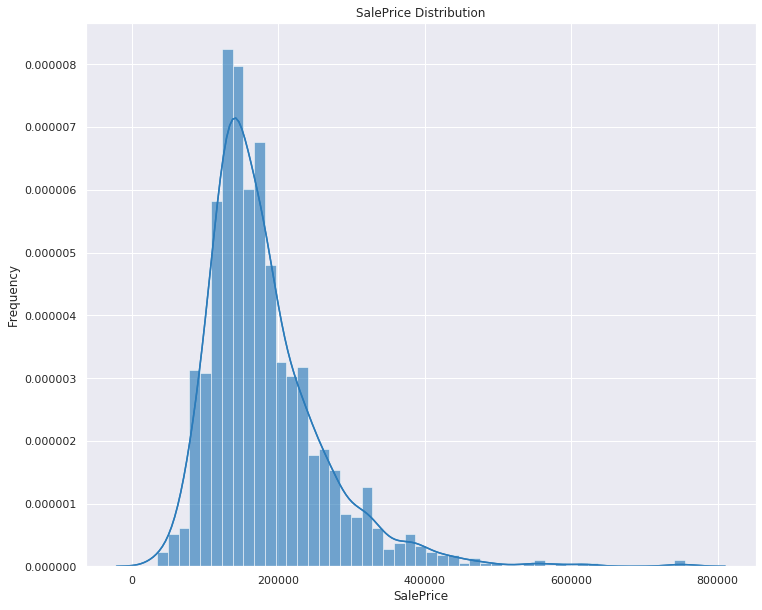

In [384]:
# Let's plot a distribution plot for the target variable column and see how the prices are distributed. 
draw_distribution(train_df, "SalePrice", kde=True)

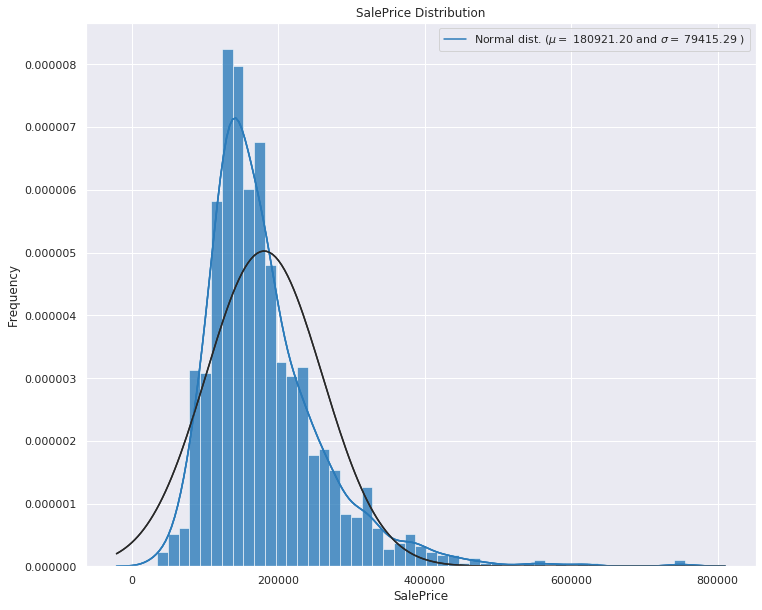

In [385]:
draw_distribution(train_df, "SalePrice",fit="norm", kde=True)

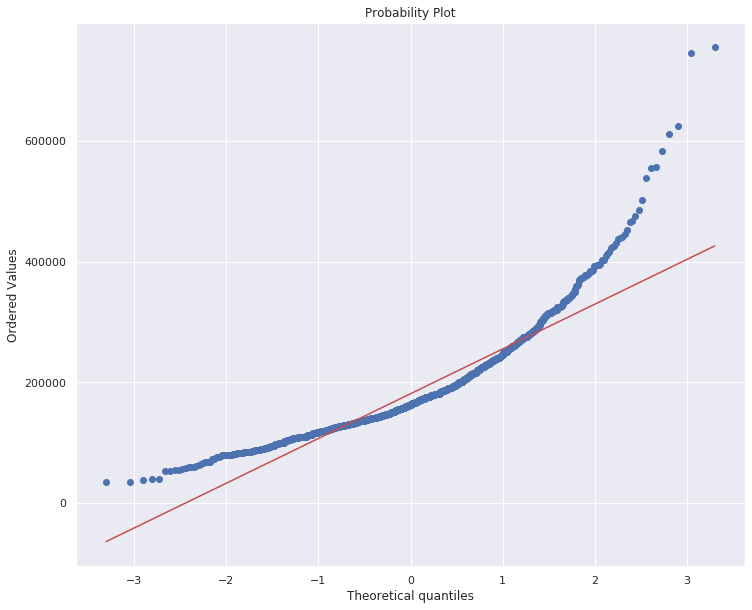

In [386]:
## QQ Plot
fig  = plt.figure(figsize=(12,10))
stats.probplot(train_df["SalePrice"], plot=plt)
plt.show();

We can see that the prices are slightly skewed to the right and centered $200,000. Let's run a descriptive statistics on our target variable.

In [359]:
train_df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

As we can see, most of the house prices are below the 75 percentile. One way to fix this by using a logarithmic scale.

#### Log Transformation of the target variable

In [364]:
df_scaled = train_df.copy()

In [365]:
df_scaled["SalePrice"] =  np.log(train_df["SalePrice"])

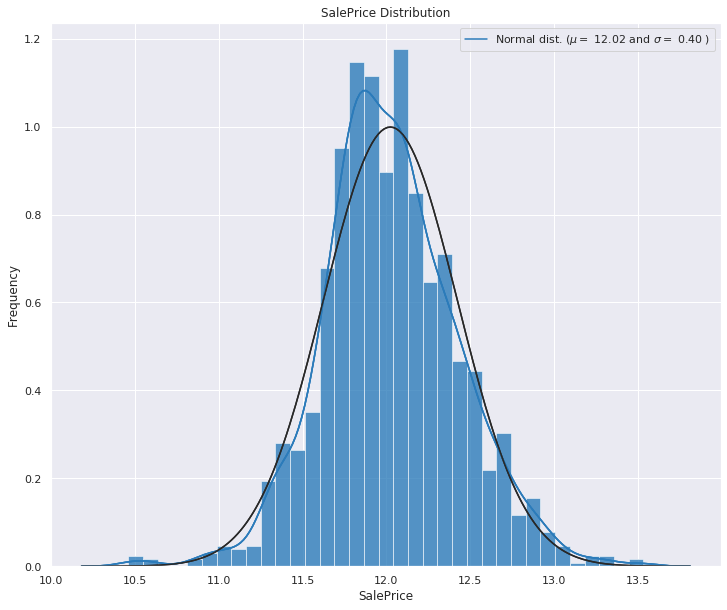

In [387]:
# Plotting the 
draw_distribution(df_scaled, "SalePrice",fit="norm", kde=True)

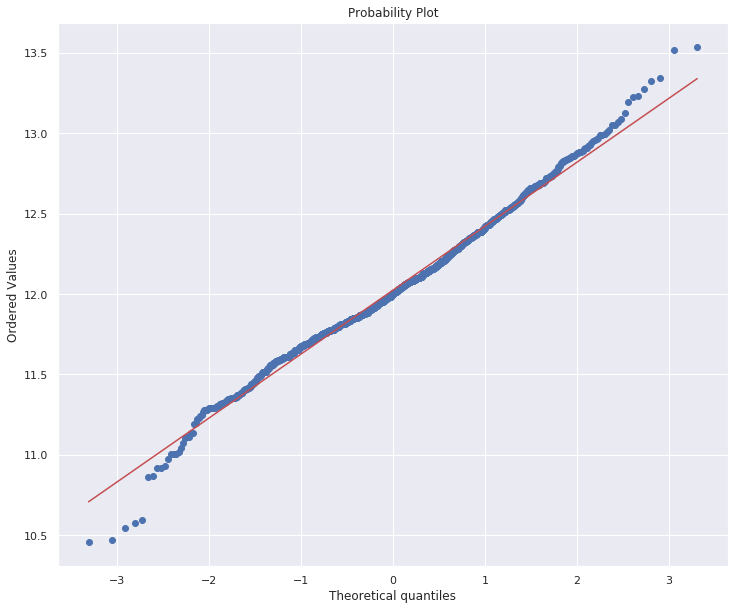

In [379]:
## QQ Plot
fig  = plt.figure(figsize=(12,10))
stats.probplot(df_scaled["SalePrice"], plot=plt)
plt.show();

### Missing Values:
In this section, I am going to look into the missing values and come up with the strategies that could help fix those. It's recommended to see if the missing values are random or they an underlying pattern.

In [398]:
# Counting the missing values per feature and picking the top 25
missing_values = df_scaled.isnull().sum().sort_values(ascending=False)[:25]
# Calculating the missing ratio and picking the top 25
ratio = ((df_scaled.isnull().sum()/df_scaled.isnull().count())*100).sort_values(ascending=False)[:25]
missing_data = pd.concat([missing_values, ratio], axis=1, keys=['Total Missing', 'Percent'])
missing_data.head(20)

,Total Missing,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


Let's visualize these for better understanding; 

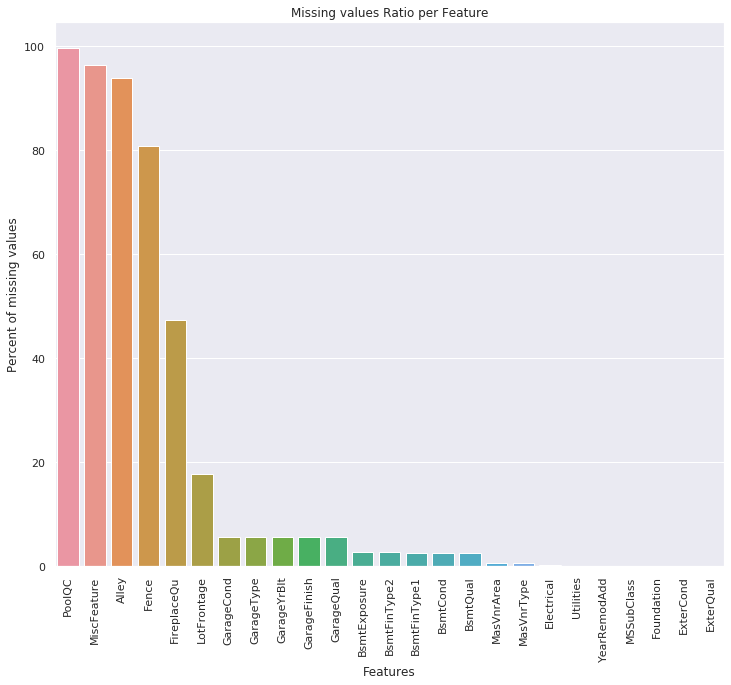

In [401]:
f, ax = plt.subplots(figsize=(12, 10))
plt.title("Missing values Ratio per Feature")
plt.xlabel("Features")
plt.ylabel("Percent of missing values")
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=ratio);

In [406]:
# Per the data description, the NA in the PoolQC column means the house did not have a pool. We can impute that with "None"
df_scaled["PoolQC"] = df_scaled["PoolQC"].fillna("None")

In [ ]:
df_scaled

### Correlation

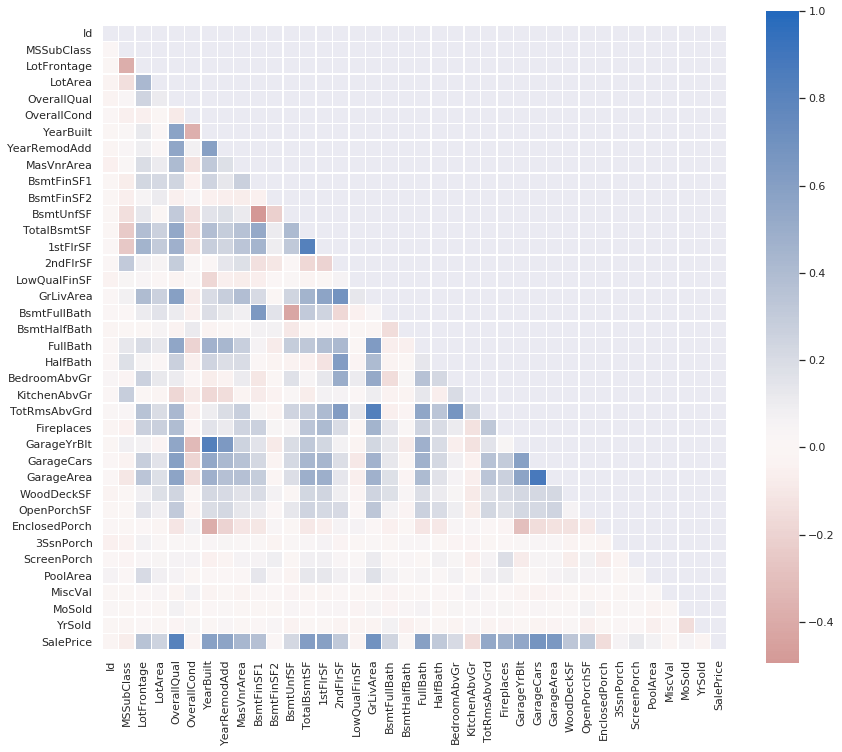

In [367]:
#Using Pearson Correlation
#plt.figure(figsize=(12,10))
# Calculate the correlation on the entire dataframe
cor = df_scaled.corr()
# Create a mask to hight the cells above the diagonal line. 
mask = np.triu(np.ones_like(cor, dtype=bool))
# Setting up the figure
f, ax = plt.subplots(figsize=(14, 12))
# Create a custom color pallete
cmap = cmap = sns.cm.vlag_r
# Draw the heatmap with the mask. 
sns.heatmap(cor, annot=False, mask=mask, square=True, linewidths=.4, 
            vmax=1, center=0, cmap=cmap);
plt.show();

As we can see from the heatmap above, we could see multicollinearity among features. For example, there is avery high correlation between GarageYrBlt and YearBuilt, or GarageCars and GarageArea. 

In the following section, I want to define a function that helps us narrow down our heatmap to the top n highly correlated variables that we want to display. 

In [368]:
def draw_heatmap(df, y_variable, no_features):
    """ This Function takes three arguments; 
        1. The dataframe that we want to draw the heatmap for
        2. The variable that we want to see the correlation of with other features for example the y-variable.
        3. The top_n. For example for top 10 variables, type 10."""
    # Calculate the correlation matrix
    cor = df.corr()
    # Get the columns for n largetst features
    columns = cor.nlargest(no_features, y_variable)[y_variable].index
    cm = np.corrcoef(df[columns].values.T)
    sns.set(font_scale=1)
    fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    # Define the color pallet
    cmap = sns.cm.vlag_r
    heat_map = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt=".2f", annot_kws={'size':12}, 
                      yticklabels=columns.values, xticklabels=columns.values,
                      linewidths=.2,vmax=1, center=0, cmap= cmap)
    return plt.show();

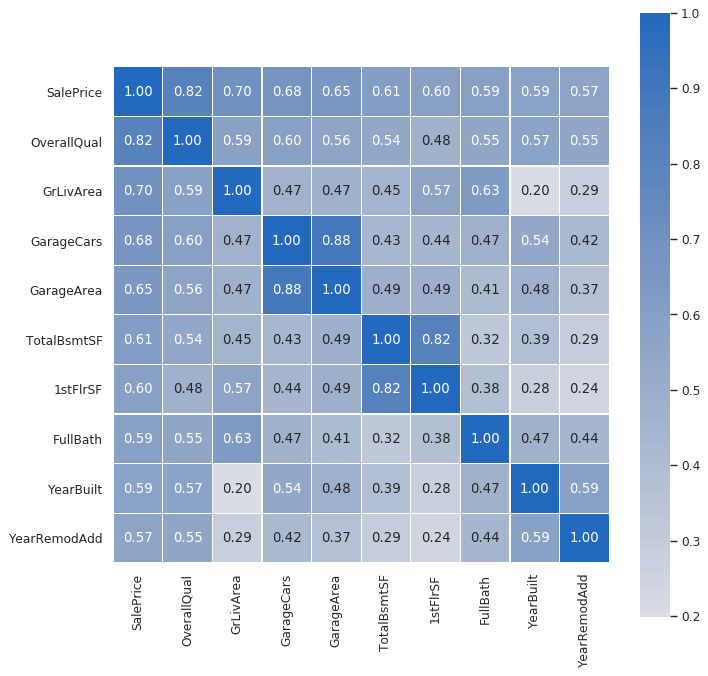

In [369]:
# Let's see the top 10 features against "SalePrice"
draw_heatmap(df_scaled, "SalePrice", 10)

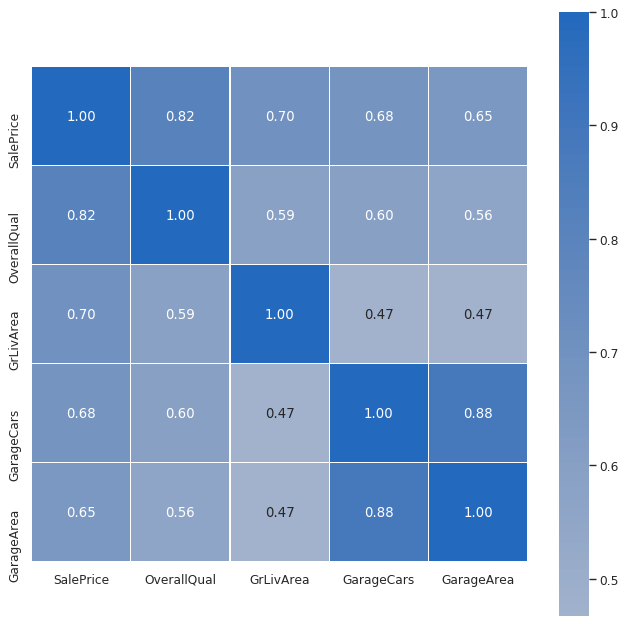

In [370]:
# Let's see the top 5 variables: 
draw_heatmap(df_scaled, "SalePrice", 5)

### Exploring the relationship between the highest correlated features and the SalePrice

Now that we know our top 5 highly correlated features, let's draw a scatter plot for some of the features to see how the data is distributed and if we could observe any outliers. 

Since I am going to be displaying the relationship between several columns, I am going to define a function that will help us do that. 

In [371]:
def draw_scatter(df, x, y="SalePrice"):
    """ This fuction helps draw a scatter plot using Seaborn's functions. 
    It takes three input arguements:
    1. The dataframe(data)
    2. our x variable that we want to display in our x axis
    3. y variable. The default column is 'SalePrice', however, we can change that 
    to whatever column we want"""
    # Set the fiture size
    plt.figure(figsize=(12,10))
    # plot the variables
    sns.scatterplot(data=df, x=x, y=y, palette="deep").set_title("Scatter Plot for {} vs. {}".format(x, y))

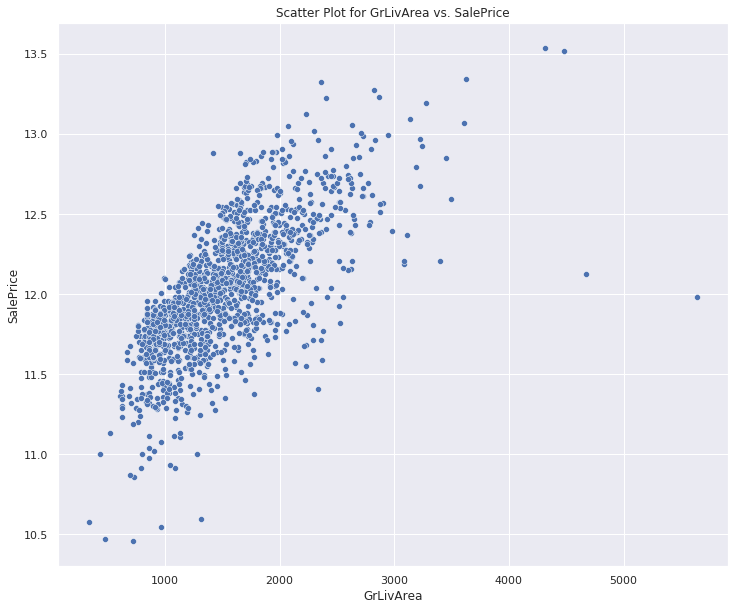

In [372]:
# Let's look at the relationship between GrLivArea and the SalePrice
draw_scatter(df_scaled, "GrLivArea")

We can see that there are a few points to the very right of the graph. I assume they are outliers. Let's draw a boxplot and confirm if those points are really outliers:

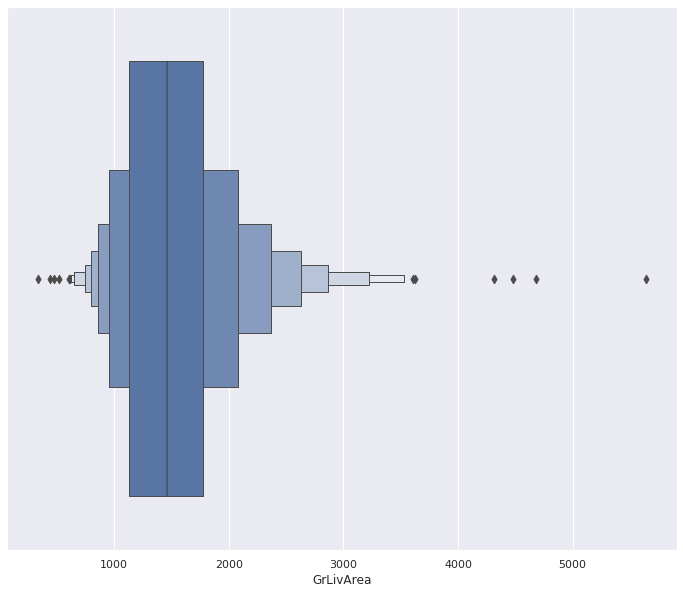

In [373]:
plt.figure(figsize=(12,10))
sns.boxenplot(x=df_scaled["GrLivArea"]);

This boxplot above confirms my assumtion that there are some outliers. 

In [374]:
def detect_outliers(data, n):
    """ This fuction helps identify outliers using the Z-Score"""
    outliers=[]
    threshold=n
    mean = np.mean(data)
    std = np.std(data)
    
    for i in data:
        z_score = (i-mean)/ std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers

In [248]:
outliers = detect_outliers(train_df["GrLivArea"].values, 4.5)

In [241]:
train_df[train_df["GrLivArea"].isin(outliers)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [256]:
# Dropping the outliers
new_df = train_df[~train_df["GrLivArea"].isin(outliers)]

In [258]:
new_df['GrLivArea'].size

1456

In [253]:
train_df["GrLivArea"].size

1460

In [277]:
# We can also look for the outliers using the quantile methods: 
# Let's define our tresholds: 
max_threshold = train_df["GrLivArea"].quantile(0.99)
min_threshold = train_df["GrLivArea"].quantile(0.01)

In [238]:
train_df[train_df["GrLivArea"] > max_threshold]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,2.5Fin,10,9,1892,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,None,0.0,Gd,Gd,BrkTil,TA,TA,Mn,Unf,0,Unf,0,1107,1107,GasA,Ex,Y,SBrkr,1518,1518,572,3608,0,0,2,1,4,1,Ex,12,Typ,2,TA,Detchd,1993.0,Unf,3,840,Ex,TA,Y,0,260,0,0,410,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1995,1996,Hip,CompShg,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,Ex,TA,Gd,GLQ,1387,Unf,0,543,1930,GasA,Ex,Y,SBrkr,1831,1796,0,3627,1,0,3,1,4,1,Gd,10,Typ,1,TA,Attchd,1995.0,Fin,3,807,TA,TA,Y,361,76,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [216]:
train_df["GrLivArea"].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

In [239]:
train_df[(train_df["GrLivArea"] > max_threshold) | (train_df["GrLivArea"] < min_threshold)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
29,30,30,RM,60.0,6324,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,BrkSide,Feedr,RRNn,1Fam,1Story,4,6,1927,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,520,520,GasA,Fa,N,SBrkr,520,0,0,520,0,0,1,0,1,1,Fa,4,Typ,0,NaN,Detchd,1920.0,Unf,1,240,Fa,TA,Y,49,0,87,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,68500
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,2.5Fin,10,9,1892,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,None,0.0,Gd,Gd,BrkTil,TA,TA,Mn,Unf,0,Unf,0,1107,1107,GasA,Ex,Y,SBrkr,1518,1518,572,3608,0,0,2,1,4,1,Ex,12,Typ,2,TA,Detchd,1993.0,Unf,3,840,Ex,TA,Y,0,260,0,0,410,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
402,403,30,RL,60.0,10200,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,8,1940,1997,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,No,Unf,0,Unf,0,672,672,GasA,Ex,Y,SBrkr,672,0,0,672,0,0,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1940.0,Unf,1,240,TA,TA,N,168,0,0,0,0,0,NaN,GdPrv,NaN,0,8,2008,WD,Normal,108000
434,435,180,RM,21.0,1890,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,SFoyer,4,7,1972,1972,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,Gd,CBlock,Gd,TA,Av,ALQ,495,Unf,0,135,630,GasA,Gd,Y,SBrkr,630,0,0,630,1,0,1,0,1,1,TA,3,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,88,0,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,81000
489,490,180,RM,21.0,1526,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,SFoyer,4,8,1970,2002,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,Gd,CBlock,Gd,TA,Av,GLQ,515,Unf,0,115,630,GasA,TA,Y,SBrkr,630,0,0,630,1,0,1,0,1,1,Gd,3,Typ,0,NaN,Attchd,1970.0,Unf,1,286,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,86000
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
528,529,30,RL,58.0,9098,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,4,7,1920,2002,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,Mn,ALQ,348,Unf,0,180,528,GasA,Ex,Y,SBrkr,605,0,0,605,1,0,1,0,2,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,144,0,0,0,NaN,NaN,NaN,0,7,2007,WD,Normal,86000
533,534,20,RL,50.0,5000,Pave,NaN,Reg,Low,AllPub,Inside,Mod,BrkSide,Norm,Norm,1Fam,1Story,1,3,1946,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,Fa,Fa,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Fa,N,FuseF,334,0,0,334,0,0,1,0,1,1,Fa,2,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,39300
614,615,180,RM,21.0,1491,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,SFoyer,4,6,1972,1972,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,Gd,TA,Av,LwQ,150,GLQ,480,0,630,GasA,Ex,Y,SBrkr,630,0,0,630,1,0,1,0,1,1,TA,3,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,96,24,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,75500
649,650,180,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,SFoyer,4,6,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,131,GLQ,499,0,630,GasA,Gd,Y,SBrkr,630,0,0,630,1,0,1,0,1

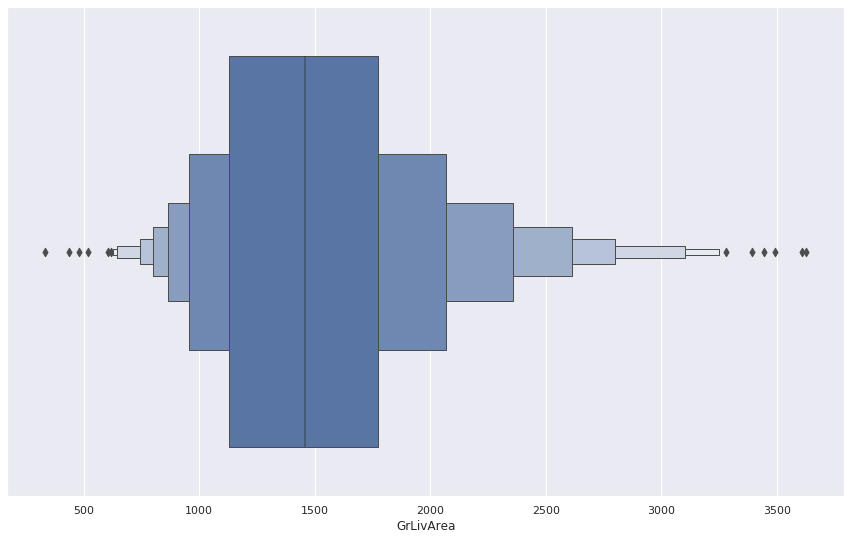

In [261]:
plt.figure(figsize=(15,9))
sns.boxenplot(x=new_df["GrLivArea"]);

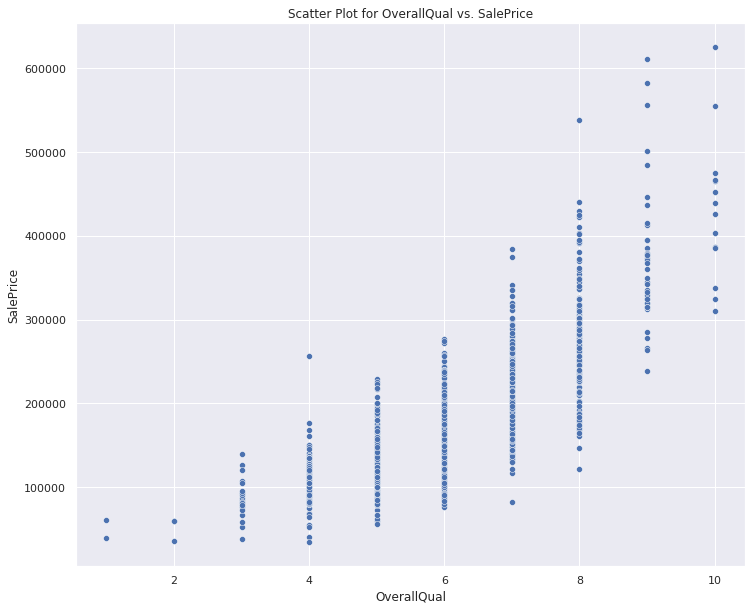

In [273]:
draw_scatter(new_df, "OverallQual")

In [ ]:
TotalBsmtSF

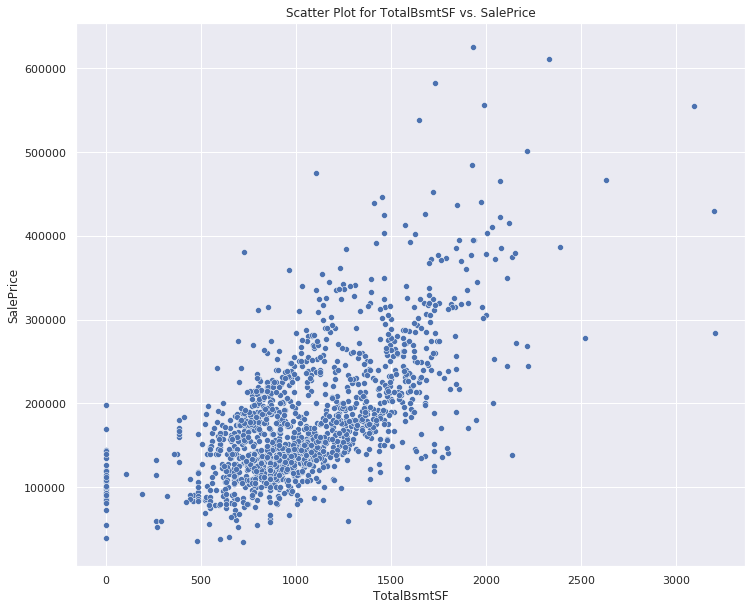

In [278]:
draw_scatter(new_df, "TotalBsmtSF")

## Dependent Variable: 

<Figure size 864x720 with 0 Axes>

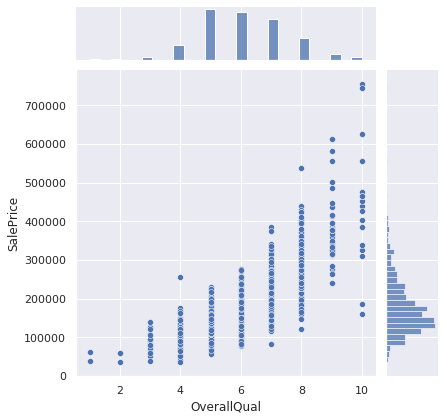

In [71]:
# Jointplot of OverallQual vs SalePrice. 
sns.jointplot(data=train_df, x="OverallQual", y="SalePrice")

/opt/tljh/user/envs/tf2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/tljh/user/envs/tf2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/tljh/user/envs/tf2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


import seaborn as sns
corr = train_df.corr()
kot = corr[corr>=.9]
plt.figure(figsize=(12,8))
sns.heatmap(kot, cmap="Greens")

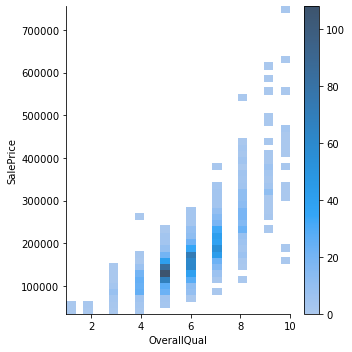

In [38]:
sns.displot(train_df, x="OverallQual", y="SalePrice", cbar=True)

In [ ]:
https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python